#**Reza Dehkordi**
#**02-26-2021**

#**Overview:**
>The task given is to find out which features of the supplied data set are strong indicators of customers of caravan insurance, in order to better be able to decide who should be given insurance and who should not be. This is imporant because ideally we would want to minimize the individauls identified as high rist, as policy holders.

# **Data:**
> Data imported from https://www.kaggle.com/uciml/caravan-insurance-challenge/home and includes 5822 real customer records. Each record consists of 86 variables, containing sociodemographic data (variables 1-43) and product ownership (variables 44-86).

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
%matplotlib inline
# forward/backward feature selection based on p-value
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


#load data
from google.colab import files
uploaded = files.upload()
import io
df = pd.read_csv(io.BytesIO(uploaded['caravan-insurance-challenge.csv']))

Saving caravan-insurance-challenge.csv to caravan-insurance-challenge.csv


#**EDA:**

shape: 
(9822, 87)

check missing values per each attirbute:
ORIGIN      0
MOSTYPE     0
MAANTHUI    0
MGEMOMV     0
MGEMLEEF    0
           ..
APLEZIER    0
AFIETS      0
AINBOED     0
ABYSTAND    0
CARAVAN     0
Length: 87, dtype: int64



Not Insured:  9236
Insured:  586


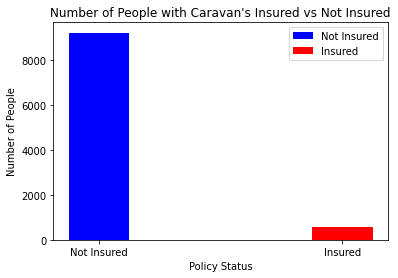

In [ ]:
# Perform EDA:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


print("shape: ")
print(df.shape)
print("\ncheck missing values per each attirbute:")
print(df.isnull().sum() )
print('\n\n')

Not_Insured_with_caravan = sum(df['CARAVAN'] == 0)
Insured_with_caravan = sum(df['CARAVAN'] == 1)

plt.bar('Not Insured', Not_Insured_with_caravan, color = 'b', width = 0.25, label='Not Insured')
plt.bar('Insured', Insured_with_caravan, color = 'r', width = 0.25, label='Insured')

#X = np.arange(1)
print("Not Insured: ",Not_Insured_with_caravan)
print("Insured: ", Insured_with_caravan)

plt.title("Number of People with Caravan's Insured vs Not Insured")
plt.xlabel("Policy Status")
plt.ylabel("Number of People")
plt.legend(loc='upper right')

Evidence of unbalance data.


Not Insured:  9236
Insured:  9236


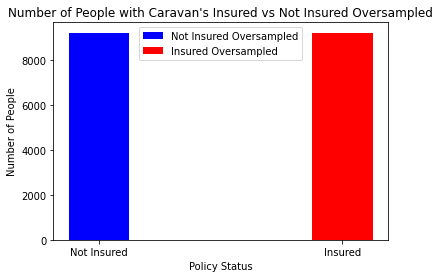

In [ ]:
from sklearn.utils import resample

not_insured= df[df['CARAVAN'] == 0]
insured = df[df['CARAVAN'] == 1]


insurance_upsampled = resample(insured,
                              replace=True, # sample with replacement
                              n_samples=len(not_insured), # match number in majority class
                              random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_insured, insurance_upsampled])

upsampled_not_insured = sum(upsampled['CARAVAN'] == 0)
upsampled_insured = sum(upsampled['CARAVAN'] == 1)

plt.bar('Not Insured', upsampled_not_insured, color = 'b', width = 0.25, label='Not Insured Oversampled')
plt.bar('Insured', upsampled_insured, color = 'r', width = 0.25, label='Insured Oversampled')
plt.title("Number of People with Caravan's Insured vs Not Insured Oversampled")
plt.xlabel("Policy Status")
plt.ylabel("Number of People")
plt.legend(loc='upper center')

#X = np.arange(1)
print("Not Insured: ",upsampled_not_insured)
print("Insured: ", upsampled_insured)


# **Modeling:**


## **I. Logistic Regression With all Features(Base Model)**

In [ ]:
df_n = df.drop(['ORIGIN'], axis=1)
y = df_n.CARAVAN
X = df_n.drop("CARAVAN", axis = 1)
slr = LogisticRegression(random_state=0).fit(X, y)

slr.score(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.940643453471798

The accuracy resulted from the score is reported at 94% which is reletivly high. However since the data is unbalanced we should test out other measures. We can compare the number of Caravan Insurance holders vs the predicted holders and see how accurate the model actually is.

In [ ]:
pred = sum(slr.predict(X))
actual = sum(y)
print("The number of actual holders %d vs predicted %d" % (actual, pred))

The number of actual holders 586 vs predicted 9


From this analysis we can see that the predictions are not anywhere near the actual amount.

In [ ]:
ups = upsampled.drop(['ORIGIN'], axis=1)
y = ups.CARAVAN
X_bal = ups.drop("CARAVAN", axis = 1)
slrs = LogisticRegression(random_state=0).fit(X, y)

slrs.score(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.6918038111736683

The accuracy of predicting non policy holders is less accurate on the balanced data set than the unbalanced data set

In [ ]:
pred = sum(slrs.predict(X_bal))
actual = sum(y)
print("The number of actual holders %d vs predicted %d" % (actual, pred))

The number of actual holders 9236 vs predicted 9281


From this analysis it can be seen that 45 non policy holders have been misclassified as policy holders


## **II. Logistic regression with stepwise selection based on p-values**

In [ ]:

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
#            best_feature = new_pval.argmin()
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(X, y)

print('resulting features:')
print(result)
print(len(result))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Add  PPERSAUT                       with p-value 2.14684e-42
Add  MKOOPKLA                       with p-value 1.36739e-21
Add  PWAPART                        with p-value 3.66711e-15
Add  APLEZIER                       with p-value 8.20766e-15
Add  MOPLHOOG                       with p-value 4.25236e-06
Add  PBRAND                         with p-value 3.92829e-06
Add  MBERBOER                       with p-value 8.31838e-06
Add  MRELGE                         with p-value 1.41977e-05
Add  PWALAND                        with p-value 0.000361295
Add  ABRAND                         with p-value 0.000937601
Add  AZEILPL                        with p-value 0.00153041
Add  MINK123M                       with p-value 0.00152554
Add  PBYSTAND                       with p-value 0.00243579
Add  PGEZONG                        with p-value 0.00485648
Add  AGEZONG                        with p-value 0.00450709
Add  MHHUUR                         with p-value 0.00630075
resulting features:
['PPERSAUT

With this stepwise selection we can locate feature with significant p values which could indicate possible importance in predicting policy holders. with threshhold_in as 0.01 and threshhold_out at 0.05, we can see 15 features with significant p values that could indicate patterns of the target. 

In [ ]:
X_sws = df[result]
lrsws = LogisticRegression(random_state=0).fit(X_sws, y)
lrsws.score(X_sws, y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9402362044390145

result is a similar 94% to the bese model. However as accurancy can be misleading we need to conduct more testing to varify the model.

In [ ]:
pred = sum(lrsws.predict(X_sws))
actual = sum(y)
print("The number of actual holders %d vs predicted %d" % (actual, pred))

The number of actual holders 586 vs predicted 7


As shown the result is poor as the model is only able to predict 1.1% of caravan insurance holders, which is worse than the original base model.

In [ ]:
X_swss = upsampled[result]
lrswss = LogisticRegression(random_state=0).fit(X_swss, y)
lrswss.score(X_swss, y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.6866608921611087

The result on the balanced data is similar to the base model.

In [ ]:
pred = sum(lrswss.predict(X_swss))
actual = sum(y)
print("The number of actual holders %d vs predicted %d" % (actual, pred))

The number of actual holders 9236 vs predicted 9148


The model has underclassified and did not classify 88 policy holders correctly.

## **III. Random Forest based on Principal component analysis feature selection**

In [ ]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

pca = PCA()
X_pca = pca.fit_transform(X)
rfpca = RandomForestClassifier().fit(X_pca, y)
rfpca.score(X_pca,y)


0.989660025985275

The model using Random Forest based on PCA has a noticeably higher accuracy on unbalanced data.



In [ ]:
pred = sum(rfpca.predict(X_pca))
actual = sum(y)
print("The number of actual holders %d vs predicted %d" % (actual, pred))

The number of actual holders 9236 vs predicted 9427


The model on the unbalanced data has incorrectly classified 191 non policy holders as policy holders. But has been the first time that the models on the unbalanced data have been able to have a significant number of correct classification of policy holders.

In [ ]:
X_pca_bal = pca.fit_transform(X_bal)
rfpca = RandomForestClassifier().fit(X_pca_bal, y)
rfpca.score(X_pca_bal,y)

0.989660025985275

In [ ]:
pred = sum(rfpca.predict(X_pca_bal))
actual = sum(y)
print("The number of actual holders %d vs predicted %d" % (actual, pred))

The number of actual holders 9236 vs predicted 9427


Identical results on the balanced and unbalanced data using pca and random forest.

## **IV. Random Forest based on feature importance feature selection**

In [ ]:
from sklearn.feature_selection import SelectFromModel

fifs = RandomForestClassifier(max_depth=3)
fifs.fit(X, y)

model = SelectFromModel(fifs, prefit=True)
Xfifs = model.transform(X)
Xfifs.shape

(18472, 19)

Using importance feature selection we were able to reduce the number of features from 87 to 19.

In [ ]:
rfifs = RandomForestClassifier(max_depth=3).fit(Xfifs, y)

rfifs.score(Xfifs, y)

0.7040385448245994

In [ ]:
pred = sum(rfifs.predict(Xfifs))
actual = sum(y)
print("The number of actual holders %d vs predicted %d" % (actual, pred))

The number of actual holders 9236 vs predicted 9275


The model misclassified 39 non policy holders as policy holders. which is the best result out of all of the purposed models. 

In [ ]:
from sklearn.feature_selection import SelectFromModel

fifs_bal = RandomForestClassifier(max_depth=3)
fifs_bal.fit(X_bal, y)

model = SelectFromModel(fifs_bal, prefit=True)
Xfifs_bal = model.transform(X_bal)
Xfifs_bal.shape

(18472, 20)

In [ ]:
rfifs_bal = RandomForestClassifier(max_depth=3).fit(Xfifs_bal, y)

rfifs_bal.score(Xfifs_bal, y)

0.7073949761801646

In [ ]:
pred = sum(rfifs_bal.predict(Xfifs_bal))
actual = sum(y)
print("The number of actual holders %d vs predicted %d" % (actual, pred))

The number of actual holders 9236 vs predicted 9305


Similar but slightly less accurate results for the balanced data.

# **Conclusion:**
> We tested four models on their ability of being able to predict Caravan policy holders and non policy holders, based on a relatively large number of features. Most of the models performed well on classifing non policy holders but failed to perform well on correctly classifing policy holders. the same models done on the balanced data resulted in a seemingly oposite effect as the accuracy of classifing policy holders was higher than the non policy holders. These in accuracies can be accounted for by the unbalanced nature of the data labels as there were far more non policy holders than holders in the data. In such a case where there exists a skewness in the data. better measurements exist such as recall and percison in order to better underestand and measure the performance of the models.